In [1]:
import seaborn as sns
sns.set()
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from sklearn.linear_model import LinearRegression
from scipy.fft import fft, rfftfreq, rfft

import prediction_functions as pf

In [2]:
#Plotting time series for average duration for MHWs and their frequency (count of events) in one plot

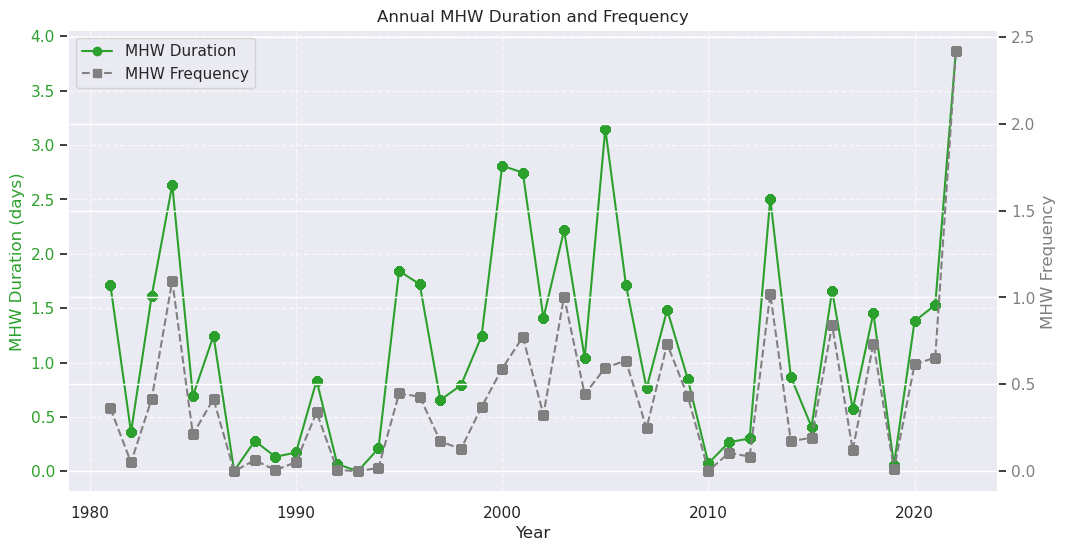

In [3]:


# Load the Annual MHW Duration file
duration_file_path = 'AnnualMHWDuration_SI_Observations.nc'
duration_data = xr.open_dataset(duration_file_path)

# Load the Annual MHW Frequency file
frequency_file_path = 'AnnualMHWFreq_SI_Observations.nc'
frequency_data = xr.open_dataset(frequency_file_path)

# Extract the necessary variables
duration = duration_data['spatial_average']
frequency = frequency_data['spatial_average']

# Extract the year information from the 'year' dimension
duration['year'] = duration['year']
frequency['year'] = frequency['year']

# Plot the time series for MHW Duration and Frequency on the same plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MHW Duration on the primary y-axis (left)
color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('MHW Duration (days)', color=color)
ax1.plot(duration['year'].values, duration.values, color=color, linestyle='-', marker='o', label='MHW Duration')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis (right) for MHW Frequency
ax2 = ax1.twinx()
color = 'grey'
ax2.set_ylabel('MHW Frequency', color=color)
ax2.plot(frequency['year'].values, frequency.values, color=color, linestyle='--', marker='s', label='MHW Frequency')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Annual MHW Duration and Frequency')
plt.savefig("Annual Duration and Frequency Observations.png")
plt.show()



#Climatology based shitty prediction

In [4]:
#Loading the duration file for hindcasts and sensitivity experiments

In [5]:
#All models have window size of 5 years, and then I vary lead years only

In [6]:
#Window size 5 years, varying lead years, 1 to 4

Lead Year 1: RMSE = 1.04
Lead Year 2: RMSE = 0.95
Lead Year 3: RMSE = 1.12
Lead Year 4: RMSE = 1.48
Lead Year 5: RMSE = 1.91


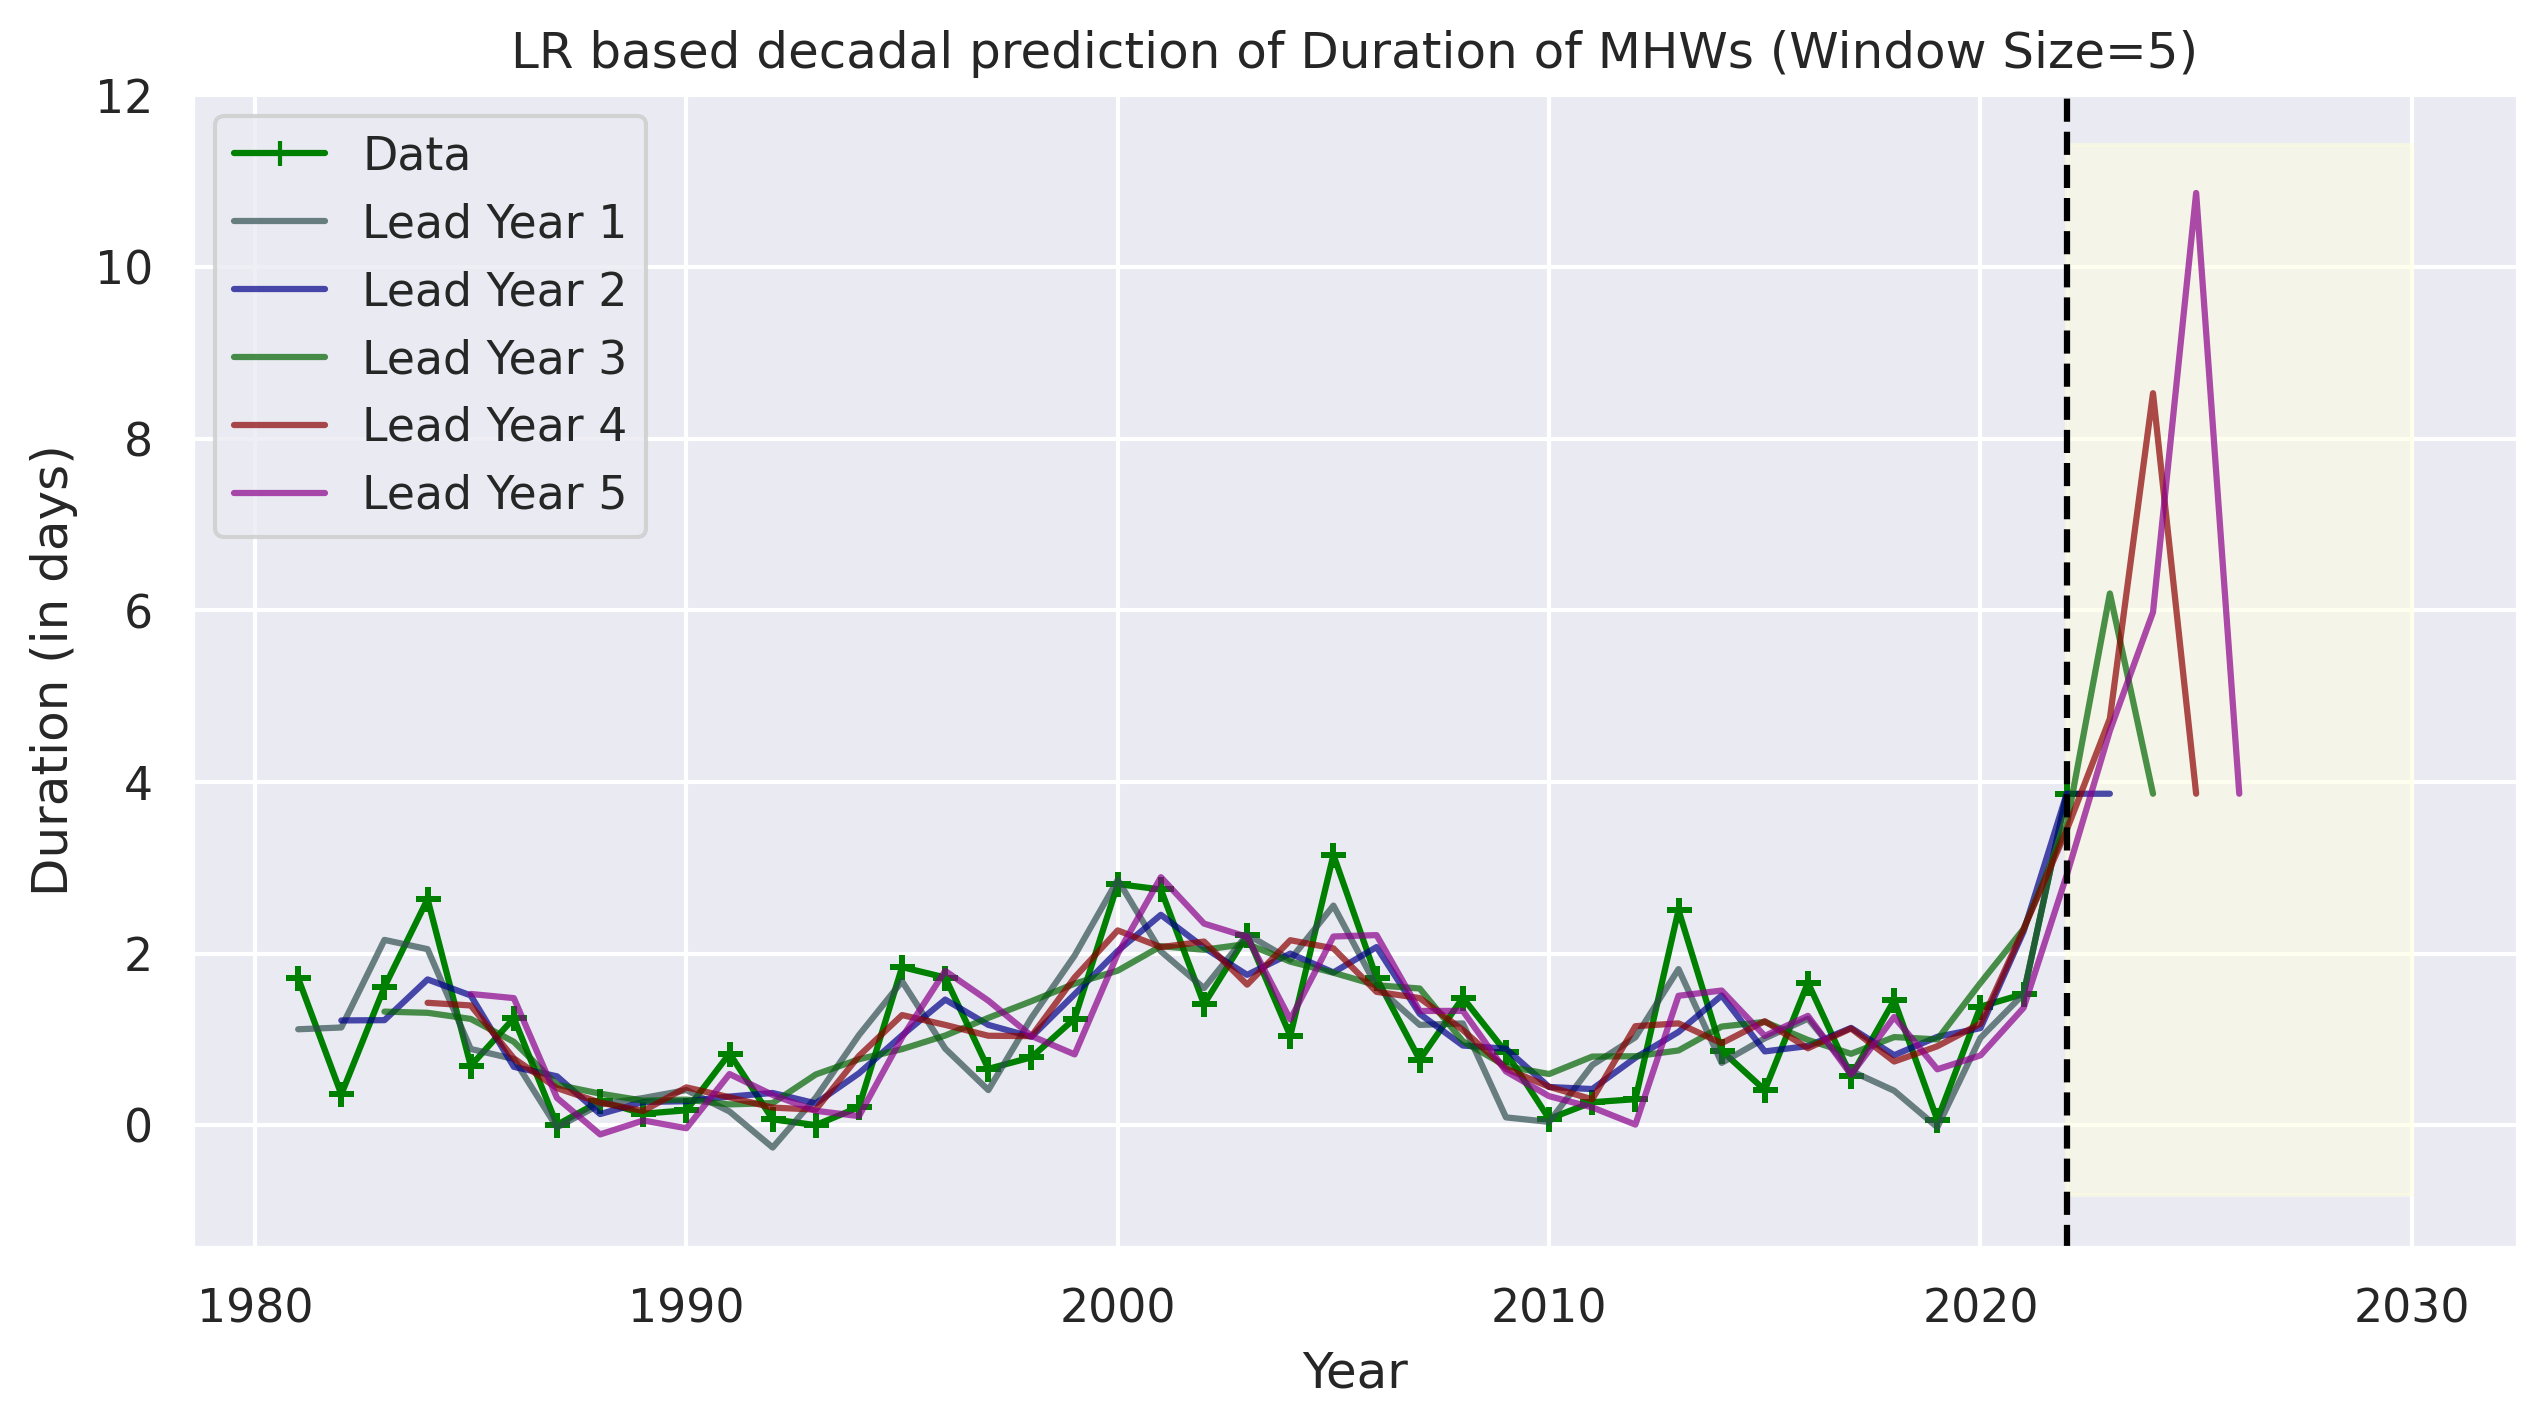

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


def f(m,b,start,end):
    values = m*np.arange(start,end,1)+b
    return values

def linear_reg_pred(df_duration, start_year, end_year, window_length=5, variable="spatial_average"):
    predictions_duration = []
    start_years = []

    for year in range(start_year, end_year - (window_length - 1)):
        window = df_duration.loc[(df_duration.index >= year) & (df_duration.index < year + window_length)]

        # Check if the window has at least one data point
        if not window.empty:
            x = window.index.to_numpy().reshape((-1, 1))
            y = window[variable].to_numpy()

            model = LinearRegression().fit(x, y)
            intercept = model.intercept_
            slope = model.coef_
            prediction_duration = f(m=slope, b=intercept, start=year, end=2030)
            predictions_duration.append(prediction_duration)
            start_years.append(year)

    return predictions_duration, start_years

# Function to calculate RMSE and Correlation Coefficient
def calculate_metrics(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    correlation = np.corrcoef(observed, predicted)[0, 1]
    return rmse, correlation


# Load data from NetCDF file into DataFrame using xarray
file_path_duration = 'AnnualMHWDuration_SI_Observations.nc'
ds_duration = xr.open_dataset(file_path_duration)
spatial_average_duration = ds_duration['spatial_average']
year = ds_duration['year']
observed_duration = spatial_average_duration.values.flatten()
df_duration = pd.DataFrame({'spatial_average': observed_duration, 'year': year.values.flatten()})
df_duration.set_index('year', inplace=True)
ds_duration.close()

start_year = 1981
end_year = 2030
window_length = 5
num_ly = 5 # Number of lead years
predict, starts = linear_reg_pred(df_duration, start_year, end_year, window_length=window_length)

# Calculate and print RMSE for all lead years
rmse_list = []

for i in range(min(num_ly, len(predict))):
    lead_year_series = [prediction_duration[i] for prediction_duration in predict]
    rmse, _ = calculate_metrics(observed_duration[0:len(lead_year_series)], lead_year_series)
    rmse_list.append(rmse)
    print(f"Lead Year {i + 1}: RMSE = {rmse:.2f}")

# Plotting code
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(df_duration.index, df_duration["spatial_average"], label="Data", marker='+', color='green')
dark_colors = ['darkslategray', 'darkblue', 'darkgreen', 'darkred', 'darkmagenta']

# Plot predictions for each lead year
for i in range(min(num_ly, len(dark_colors))):
    ly_i = [prediction_duration[i] for prediction_duration in predict]
    plt.plot(np.arange(len(ly_i)) + starts[i], ly_i, label=f"Lead Year {i + 1}", alpha=0.7, color=dark_colors[i])

# Add vertical line at x=2022
plt.axvline(x=2022, color='black', linestyle='--')
# Fill the space to the right of the vertical line with light coral color
plt.fill_betweenx(y=plt.ylim(), x1=2022, x2=2030, color='lightyellow', alpha=0.5)
plt.title("LR based decadal prediction of Duration of MHWs (Window Size=5)")
plt.xlabel("Year")
plt.ylabel("Duration (in days)")
plt.legend()
plt.show()




#Adding Pearson Correlation

In [8]:
#Window Size =10

Lead Year 1: RMSE = 1.08
Lead Year 2: RMSE = 0.99
Lead Year 3: RMSE = 1.12
Lead Year 4: RMSE = 1.41
Lead Year 5: RMSE = 1.79


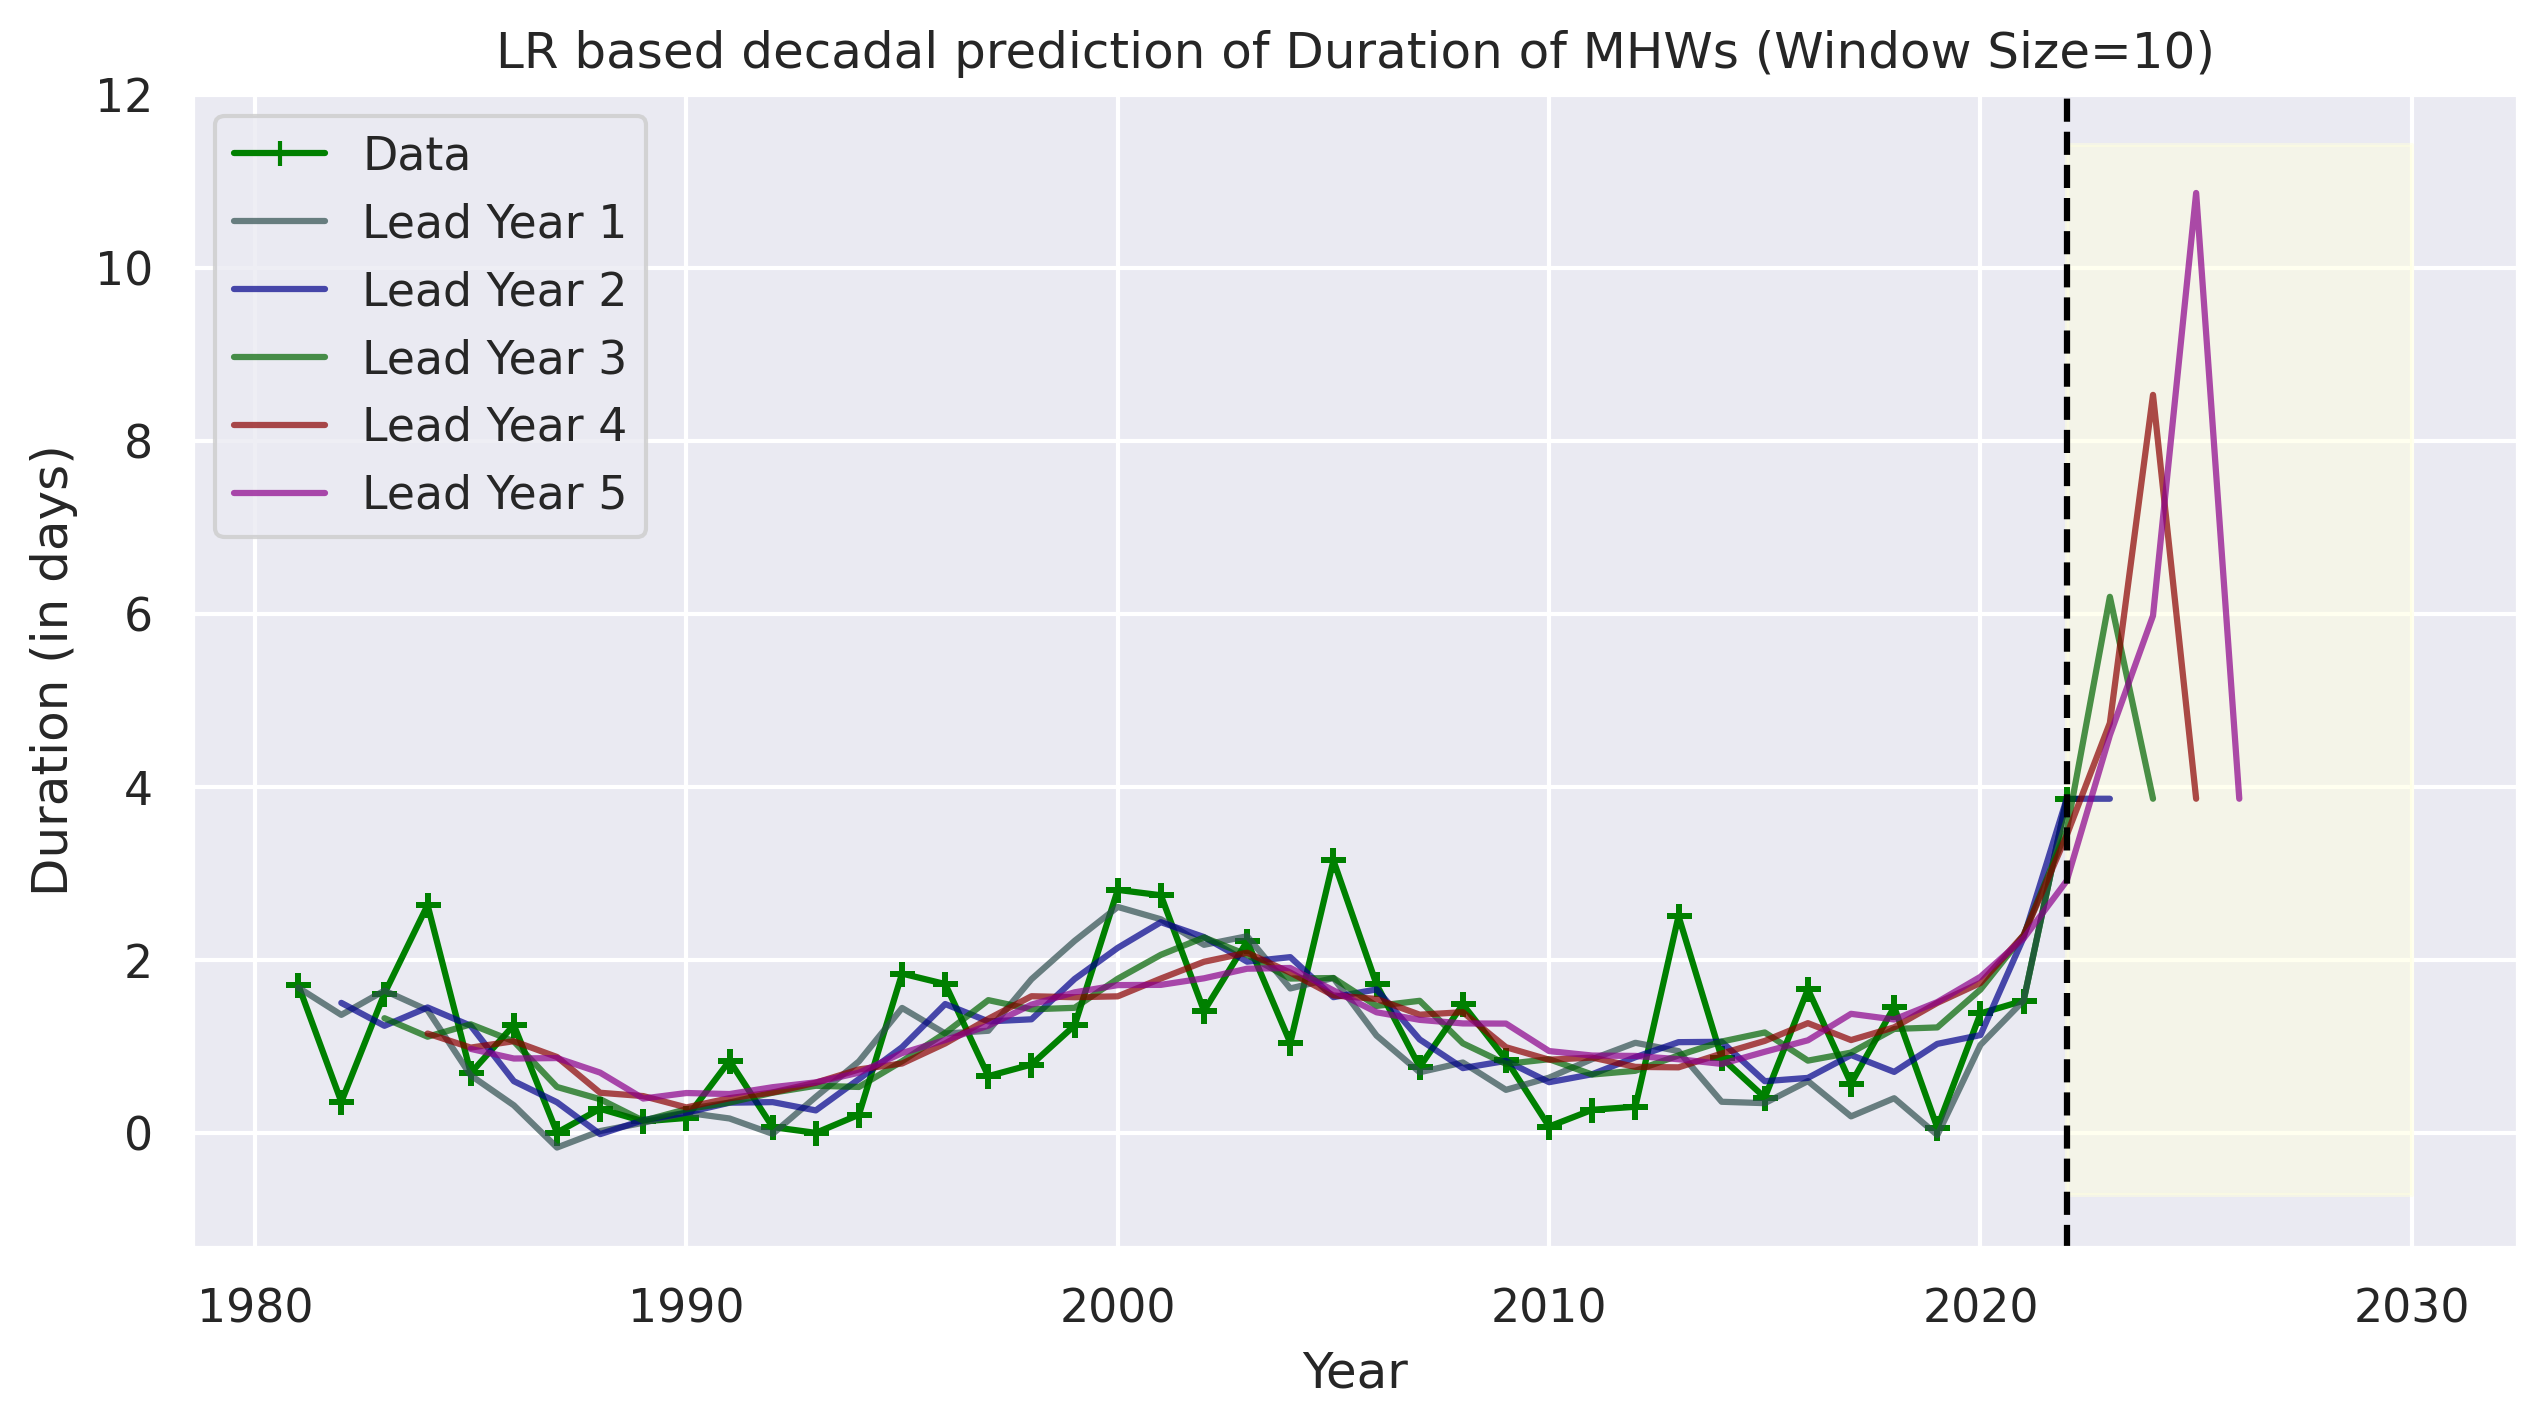

In [9]:



def f(m,b,start,end):
    values = m*np.arange(start,end,1)+b
    return values


# Linear regression function
def linear_reg_pred(df_duration, start_year, end_year, window_length=10, variable="spatial_average"):
    predictions_duration = []
    start_years = []

    for year in range(start_year, end_year - (window_length - 1)):
        window = df_duration.loc[(df_duration.index >= year) & (df_duration.index < year + window_length)]

        # Check if the window has at least one data point
        if not window.empty:
            x = window.index.to_numpy().reshape((-1, 1))
            y = window[variable].to_numpy()

            model = LinearRegression().fit(x, y)
            intercept = model.intercept_
            slope = model.coef_
            prediction_duration = f(m=slope, b=intercept, start=year, end=2030)
            predictions_duration.append(prediction_duration)
            start_years.append(year)

    return predictions_duration, start_years

# Function to calculate RMSE and Correlation Coefficient
def calculate_metrics(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    correlation = np.corrcoef(predicted, observed)[0, 1]
    return rmse, correlation

# Load data from NetCDF file into DataFrame using xarray
file_path_duration = 'AnnualMHWDuration_SI_Observations.nc'
ds_duration = xr.open_dataset(file_path_duration)
spatial_average_duration = ds_duration['spatial_average']
year = ds_duration['year']
observed_duration = spatial_average_duration.values.flatten()
df_duration = pd.DataFrame({'spatial_average': observed_duration, 'year': year.values.flatten()})
df_duration.set_index('year', inplace=True)
ds_duration.close()

start_year = 1981
end_year = 2033
window_length = 10
num_ly = 5  # Number of lead years
predict, starts = linear_reg_pred(df_duration, start_year, end_year, window_length=window_length)

# Calculate and print RMSE for all lead years
rmse_list = []

for i in range(min(num_ly, len(predict))):
    lead_year_series = [prediction_duration[i] for prediction_duration in predict]
    rmse, _ = calculate_metrics(observed_duration[0:len(lead_year_series)], lead_year_series)
    rmse_list.append(rmse)
    print(f"Lead Year {i + 1}: RMSE = {rmse:.2f}")

# Plotting code
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(df_duration.index, df_duration["spatial_average"], label="Data", marker='+', color='green')
dark_colors = ['darkslategray', 'darkblue', 'darkgreen', 'darkred', 'darkmagenta']

# Plot predictions for each lead year
for i in range(min(num_ly, len(dark_colors))):
    ly_i = [prediction_duration[i] for prediction_duration in predict]
    plt.plot(np.arange(len(ly_i)) + starts[i], ly_i, label=f"Lead Year {i + 1}", alpha=0.7, color=dark_colors[i])

# Add vertical line at x=2022
plt.axvline(x=2022, color='black', linestyle='--')
# Fill the space to the right of the vertical line with light coral color
plt.fill_betweenx(y=plt.ylim(), x1=2022, x2=2030, color='lightyellow', alpha=0.5)
plt.title("LR based decadal prediction of Duration of MHWs (Window Size=10)")
plt.xlabel("Year")
plt.ylabel("Duration (in days)")
plt.legend()
plt.show()



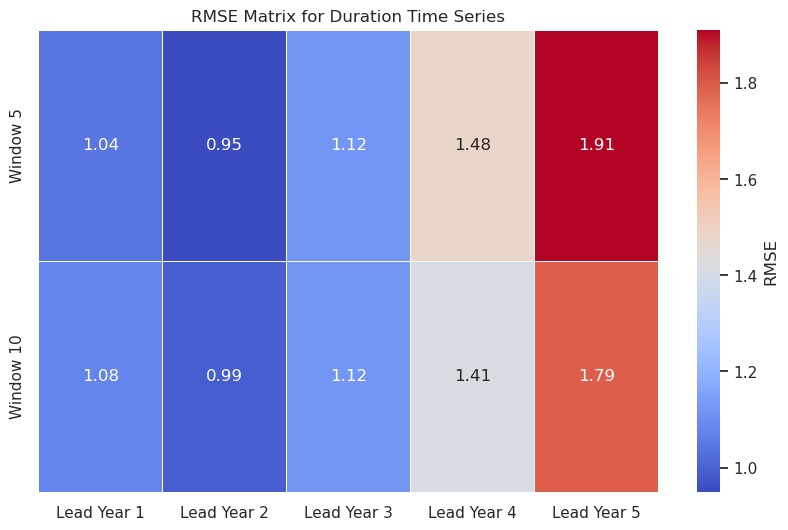

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# RMSE values
rmse_values = [
    [1.04, 0.95, 1.12, 1.48,1.91],
    [1.08, 0.99, 1.12, 1.41,1.79]
]

# Lead years and window sizes
lead_years = ['Lead Year 1', 'Lead Year 2', 'Lead Year 3', 'Lead Year 4','Lead Year 5']
window_sizes = ['Window 5', 'Window 10']

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(rmse_values, columns=lead_years, index=window_sizes)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'RMSE'})
plt.title('RMSE Matrix for Duration Time Series')
plt.show()


Frequency of HEATWAVES

In [11]:
#5 year window

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambafo

RMSE for Lead Year 1: 0.56
RMSE for Lead Year 2: 0.68
RMSE for Lead Year 3: 0.93
RMSE for Lead Year 4: 1.22
RMSE for Lead Year 5: 1.53


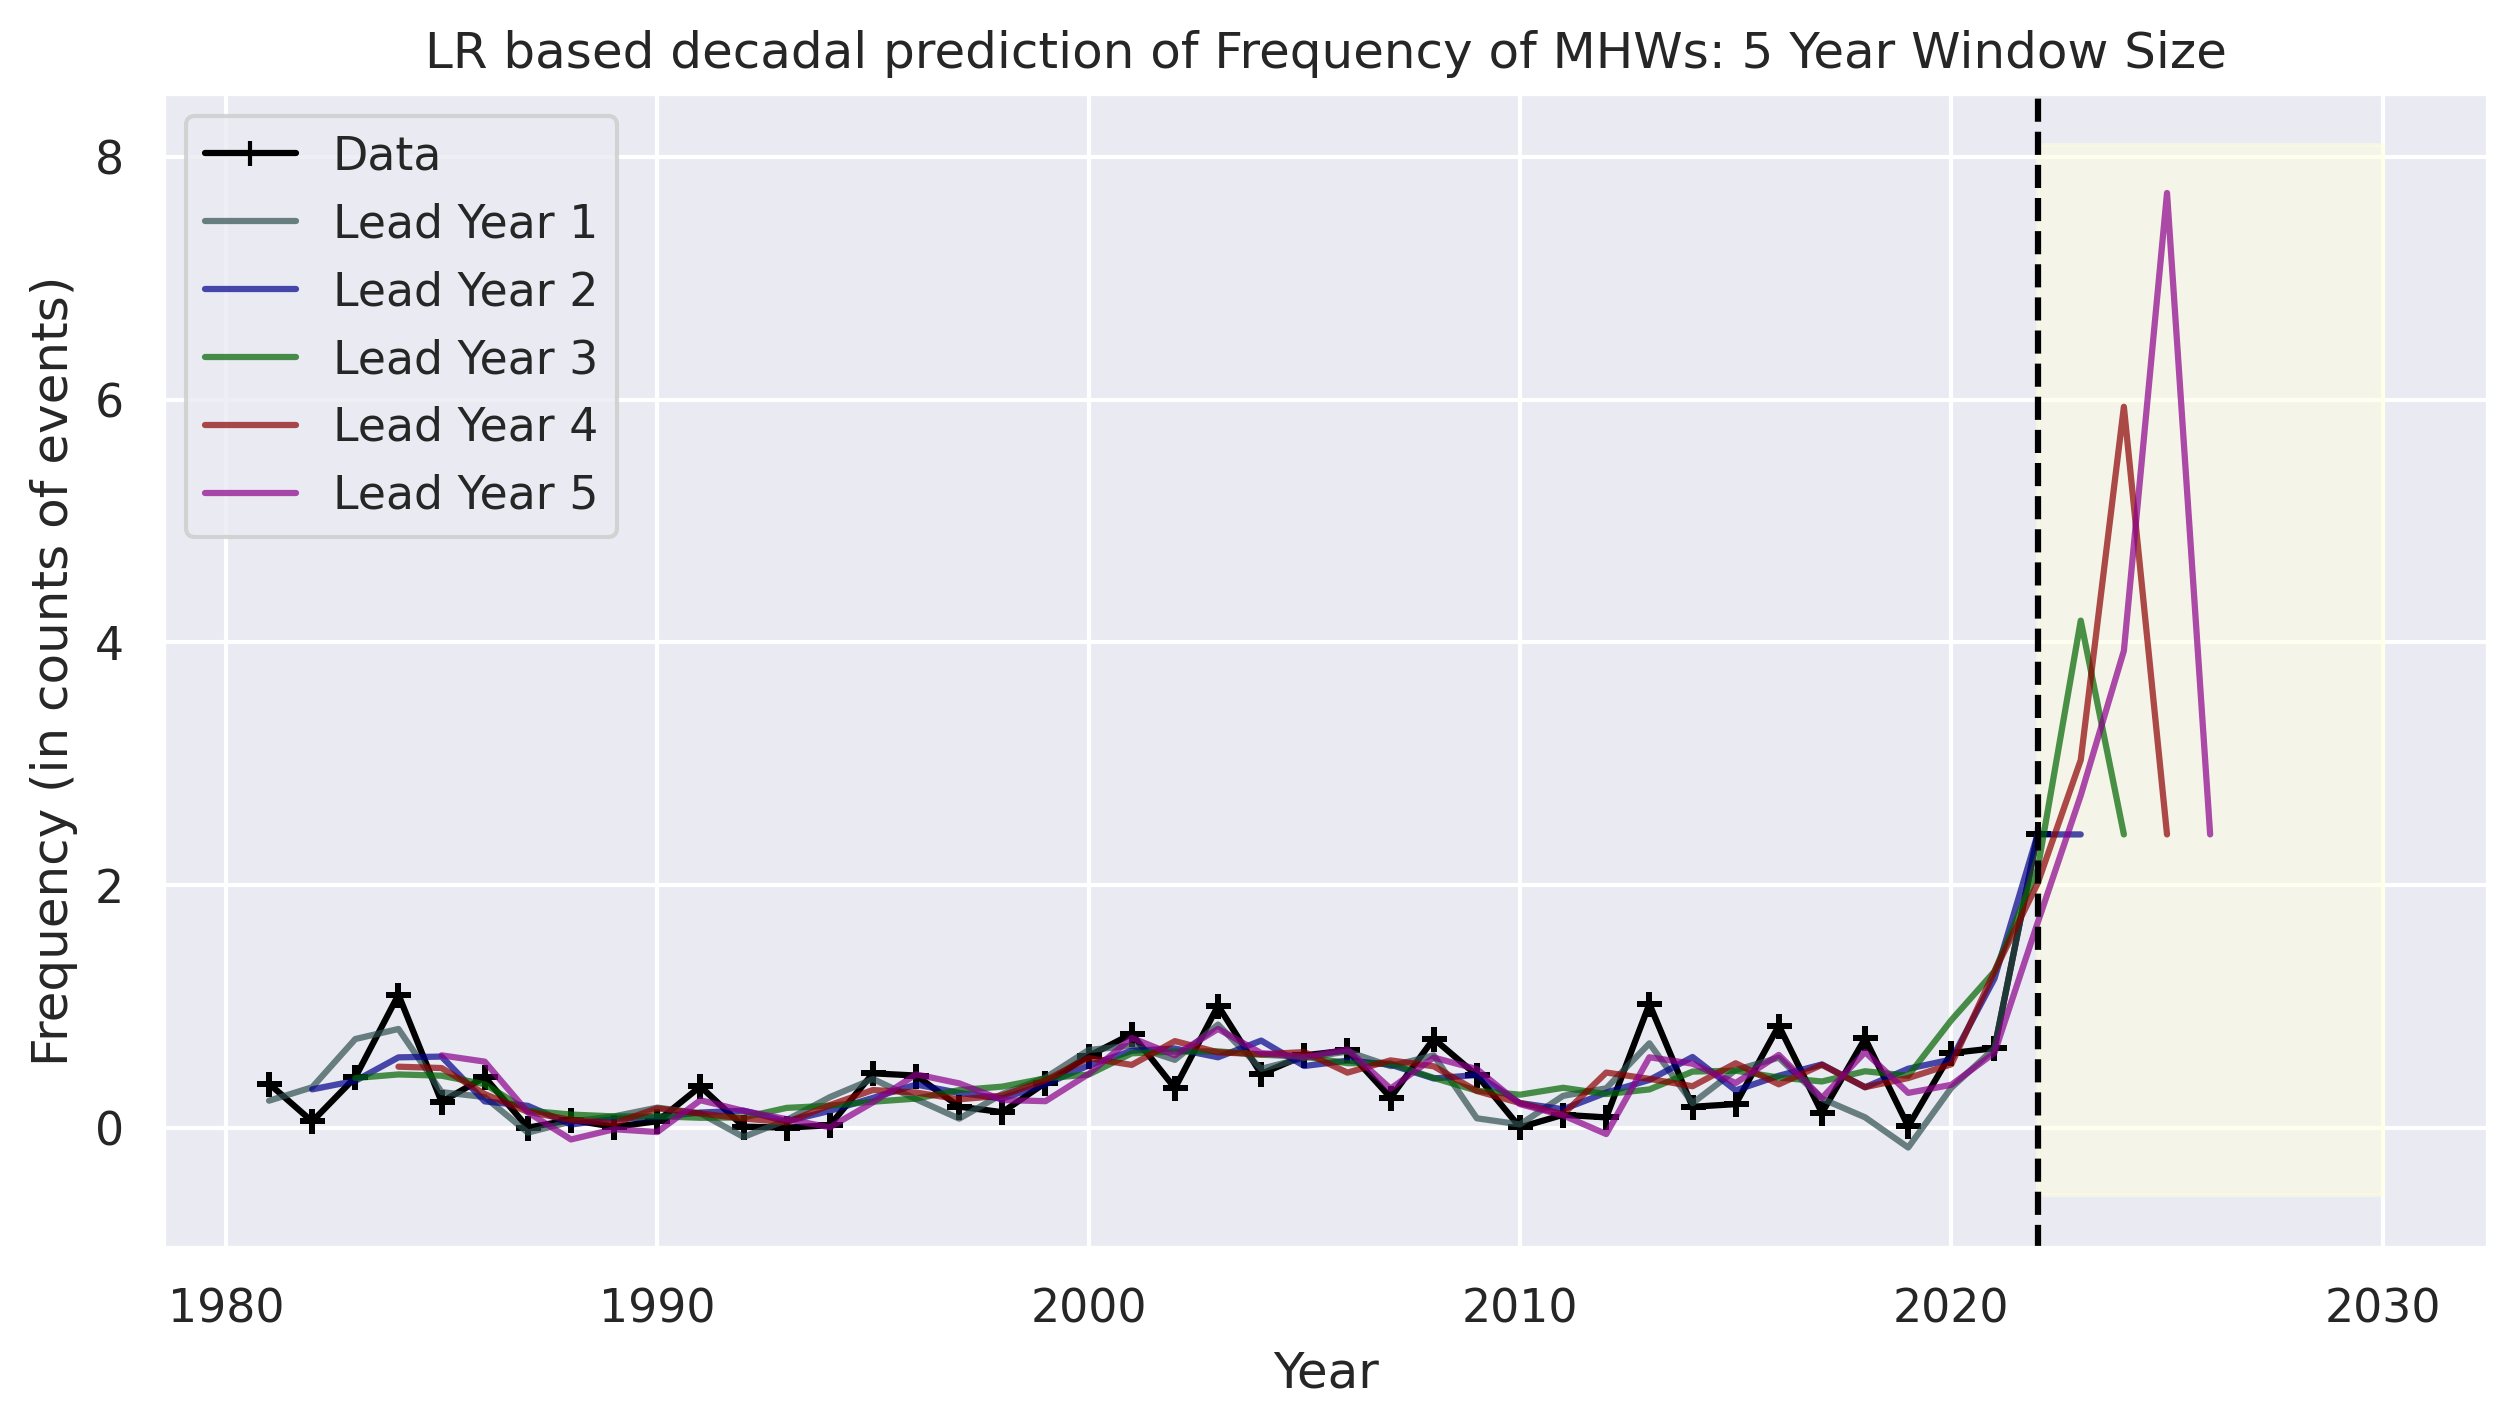

In [12]:



# Linear regression function
def linear_reg_pred(df_frequency, start_year, end_year, window_length=5, variable="spatial_average"):
    predictions_frequency = []
    start_years = []

    for year in range(start_year, end_year - (window_length - 1)):
        window = df_frequency.loc[(df_frequency.index >= year) & (df_frequency.index < year + window_length)]

        # Check if the window has at least one data point
        if not window.empty:
            x = window.index.to_numpy().reshape((-1, 1))
            y = window[variable].to_numpy()

            model = LinearRegression().fit(x, y)
            intercept = model.intercept_
            slope = model.coef_
            prediction_frequency = f(m=slope, b=intercept, start=year, end=2030)
            predictions_frequency.append(prediction_frequency)
            start_years.append(year)

    return predictions_frequency, start_years

# Function to calculate RMSE and Correlation Coefficient
def calculate_metrics(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    correlation = np.corrcoef(predicted, observed)[0, 1]
    return rmse, correlation

# Load data from NetCDF file into DataFrame using xarray
file_path_frequency = 'AnnualMHWFreq_SI_Observations.nc'
ds_frequency = xr.open_dataset(file_path_frequency)
spatial_average_frequency = ds_frequency['spatial_average']
year = ds_frequency['year']
df_frequency = pd.DataFrame({'spatial_average': spatial_average_frequency.values.flatten(), 'year': year.values.flatten()})
df_frequency.set_index('year', inplace=True)
ds_frequency.close()  # Fix: Close the dataset

start_year = 1981
end_year = 2030
window_length = 5
num_ly = 5
predict_frequency, starts = linear_reg_pred(df_frequency, start_year, end_year, window_length=window_length)
correlation_frequency = []

plt.figure(figsize=(10, 5), dpi=300)

plt.plot(df_frequency.index, df_frequency["spatial_average"], label="Data", marker='+', color='black')

# Define dark colors for lead years
dark_colors = ['darkslategray', 'darkblue', 'darkgreen', 'darkred', 'darkmagenta', 'darkorange', 'darkcyan', 'darkviolet']

for i in range(min(num_ly, len(dark_colors))):
    ly_i = [prediction_frequency[i] for prediction_frequency in predict_frequency]
    correlation_frequency.append(np.corrcoef(ly_i, df_frequency["spatial_average"][0:len(ly_i)])[0, 1])
    plt.plot(np.arange(len(ly_i)) + starts[i], ly_i, label=f"Lead Year {i + 1}", alpha=0.7, color=dark_colors[i])

    # Calculate RMSE for each lead year
    observed_frequency = df_frequency["spatial_average"][starts[i]:starts[i] + len(ly_i)]
    rmse, _ = calculate_metrics(observed_frequency, ly_i)
    print(f"RMSE for Lead Year {i + 1}: {rmse:.2f}")

# Add vertical line at x=2022
plt.axvline(x=2022, color='black', linestyle='--')
# Fill the space to the right of the vertical line with light coral color
plt.fill_betweenx(y=plt.ylim(), x1=2022, x2=2030, color='lightyellow', alpha=0.5)
plt.title("LR based decadal prediction of Frequency of MHWs: 5 Year Window Size")
plt.xlabel("Year")
plt.ylabel("Frequency (in counts of events)")
plt.legend()
plt.show()


In [13]:
#10 year window size

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambafo

RMSE for Lead Year 1: 0.53
RMSE for Lead Year 2: 0.67
RMSE for Lead Year 3: 0.93
RMSE for Lead Year 4: 1.22
RMSE for Lead Year 5: 1.54


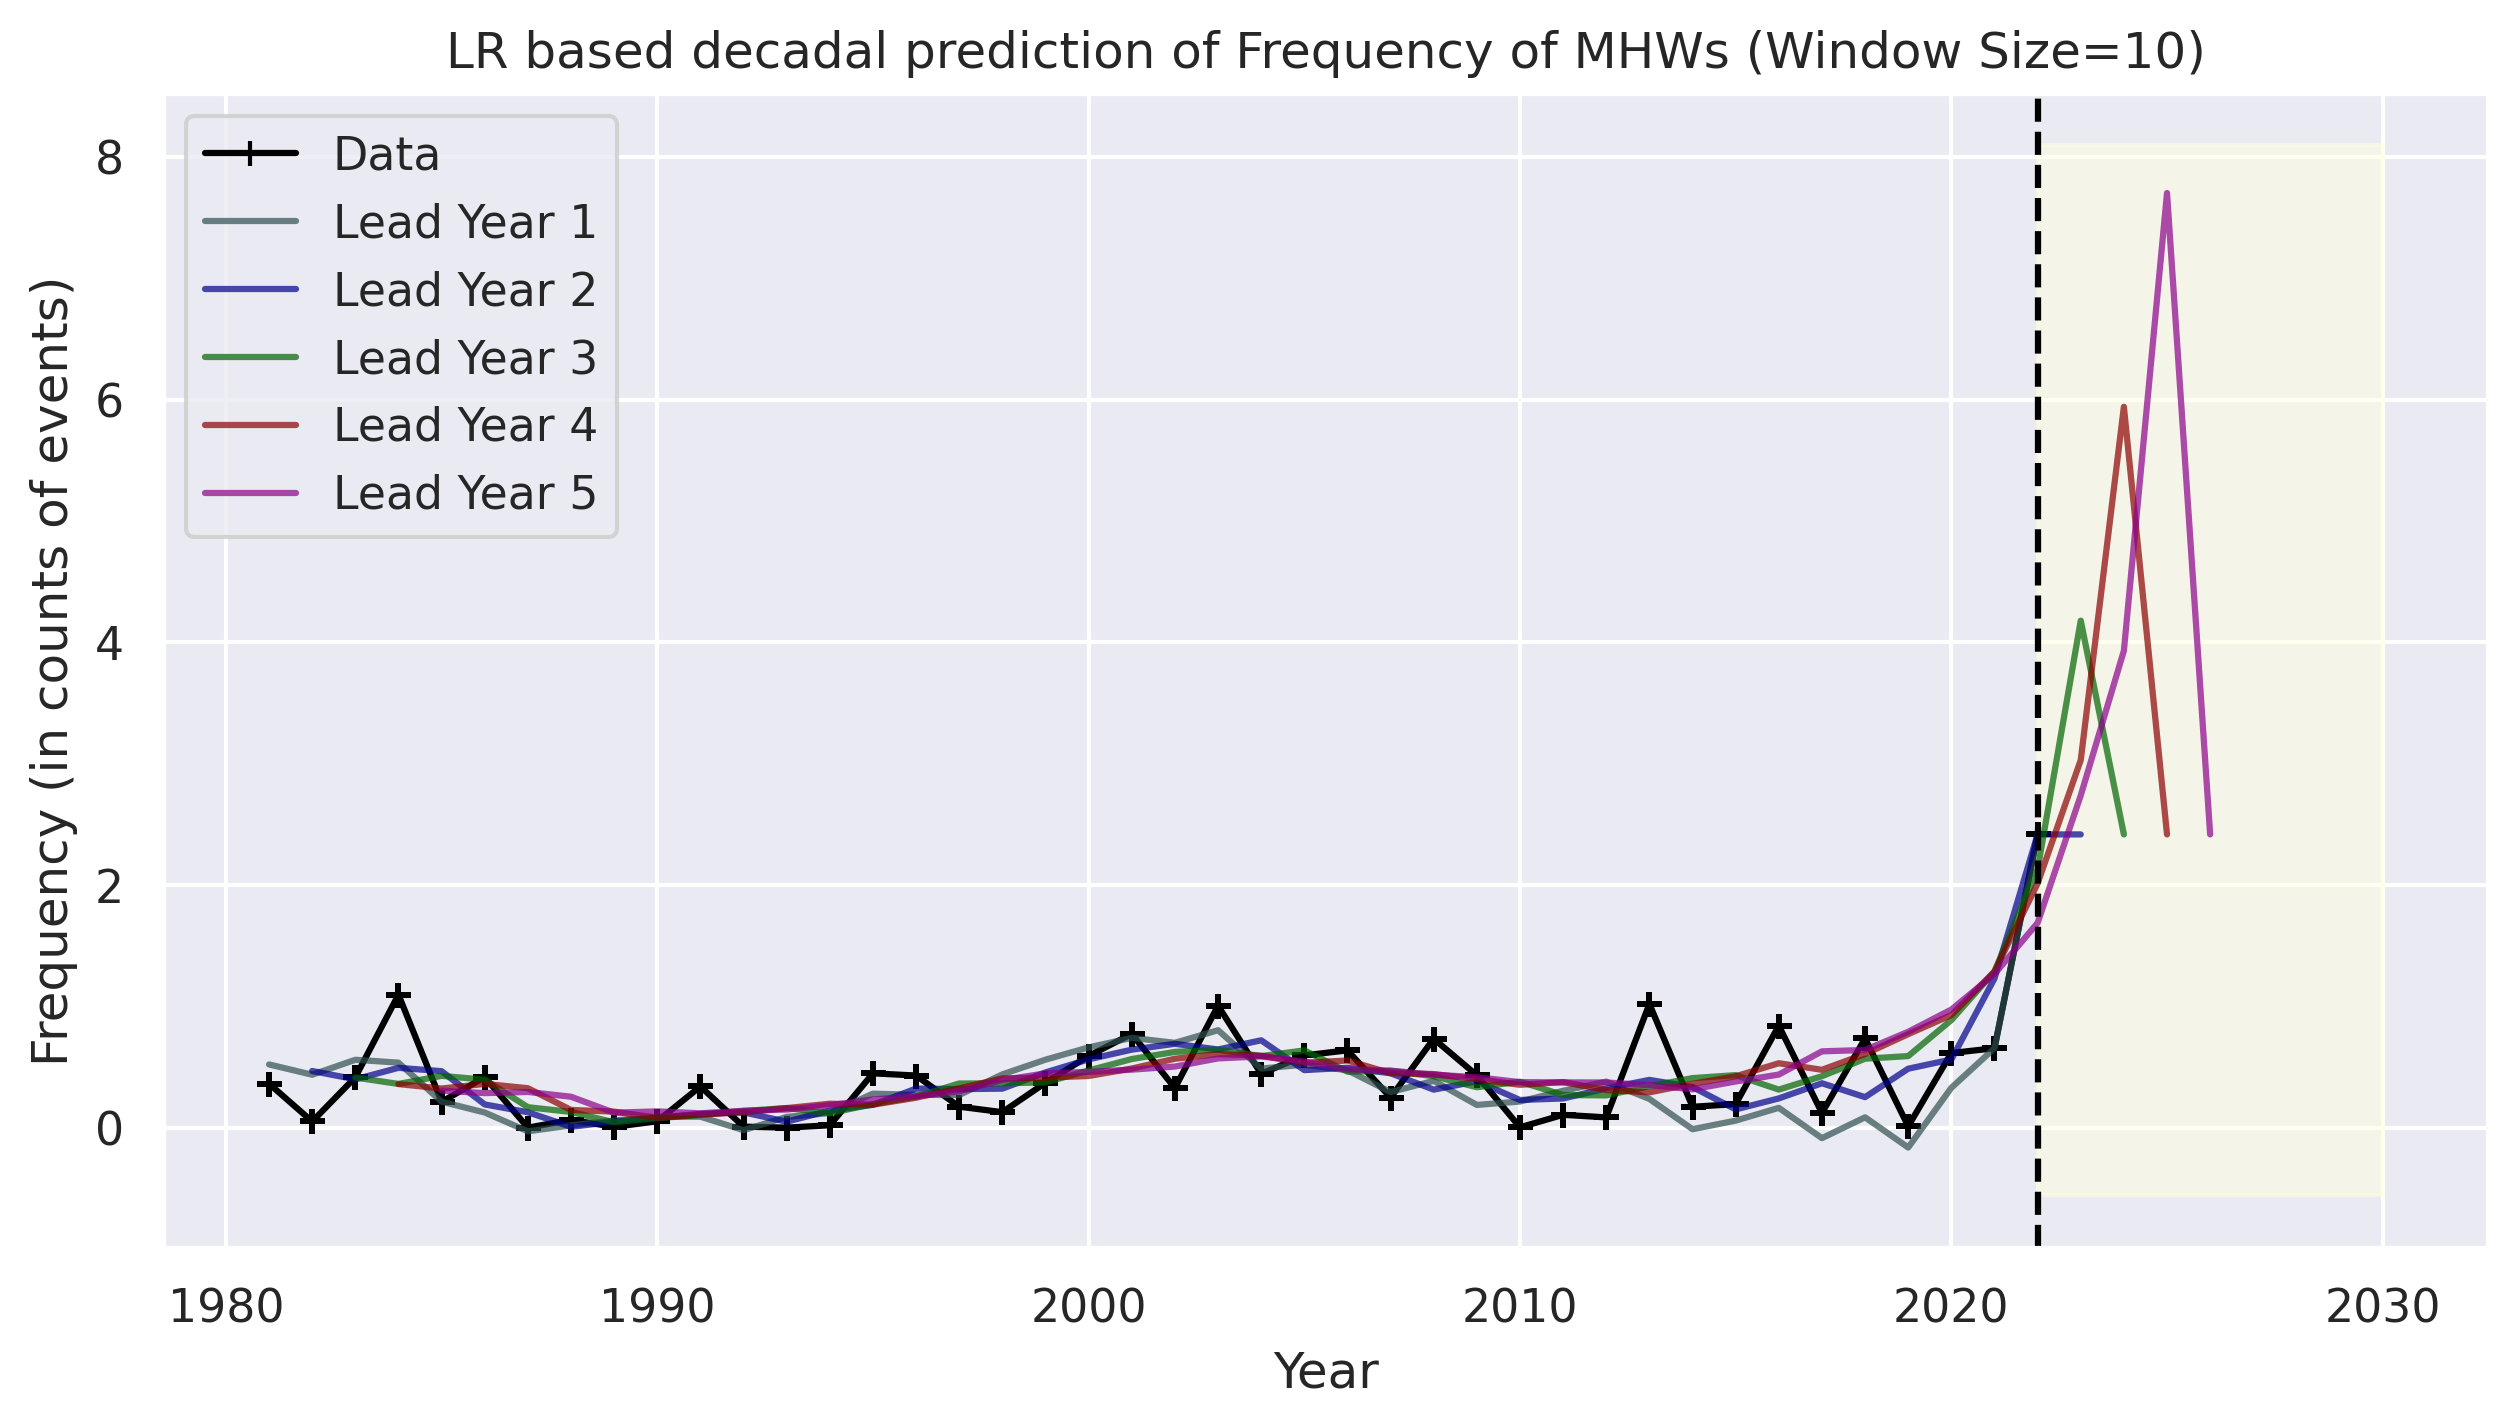

In [14]:



# Linear regression function
def linear_reg_pred(df_frequency, start_year, end_year, window_length=10, variable="spatial_average"):
    predictions_frequency = []
    start_years = []

    for year in range(start_year, end_year - (window_length - 1)):
        window = df_frequency.loc[(df_frequency.index >= year) & (df_frequency.index < year + window_length)]

        # Check if the window has at least one data point
        if not window.empty:
            x = window.index.to_numpy().reshape((-1, 1))
            y = window[variable].to_numpy()

            model = LinearRegression().fit(x, y)
            intercept = model.intercept_
            slope = model.coef_
            prediction_frequency = f(m=slope, b=intercept, start=year, end=2030)
            predictions_frequency.append(prediction_frequency)
            start_years.append(year)

    return predictions_frequency, start_years

# Function to calculate RMSE and Correlation Coefficient
def calculate_metrics(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    correlation = np.corrcoef(predicted, observed)[0, 1]
    return rmse, correlation

# Load data from NetCDF file into DataFrame using xarray
file_path_frequency = 'AnnualMHWFreq_SI_Observations.nc'
ds_frequency = xr.open_dataset(file_path_frequency)
spatial_average_frequency = ds_frequency['spatial_average']
year = ds_frequency['year']
df_frequency = pd.DataFrame({'spatial_average': spatial_average_frequency.values.flatten(), 'year': year.values.flatten()})
df_frequency.set_index('year', inplace=True)
ds_frequency.close()  # Fix: Close the dataset

start_year = 1981
end_year = 2033
window_length = 10
num_ly = 5
predict_frequency, starts = linear_reg_pred(df_frequency, start_year, end_year, window_length=window_length)
correlation_frequency = []

plt.figure(figsize=(10, 5), dpi=300)

plt.plot(df_frequency.index, df_frequency["spatial_average"], label="Data", marker='+', color='black')

# Define dark colors for lead years
dark_colors = ['darkslategray', 'darkblue', 'darkgreen', 'darkred', 'darkmagenta', 'darkorange', 'darkcyan', 'darkviolet']

for i in range(min(num_ly, len(dark_colors))):
    ly_i = [prediction_frequency[i] for prediction_frequency in predict_frequency]
    correlation_frequency.append(np.corrcoef(ly_i, df_frequency["spatial_average"][0:len(ly_i)])[0, 1])
    plt.plot(np.arange(len(ly_i)) + starts[i], ly_i, label=f"Lead Year {i + 1}", alpha=0.7, color=dark_colors[i])

    # Calculate RMSE for each lead year
    observed_frequency = df_frequency["spatial_average"][starts[i]:starts[i] + len(ly_i)]
    rmse, _ = calculate_metrics(observed_frequency, ly_i)
    print(f"RMSE for Lead Year {i + 1}: {rmse:.2f}")

# Add vertical line at x=2022
plt.axvline(x=2022, color='black', linestyle='--')
# Fill the space to the right of the vertical line with light coral color
plt.fill_betweenx(y=plt.ylim(), x1=2022, x2=2030, color='lightyellow', alpha=0.5)
plt.title("LR based decadal prediction of Frequency of MHWs (Window Size=10)")
plt.xlabel("Year")
plt.ylabel("Frequency (in counts of events)")
plt.legend()
plt.show()


In [15]:
#RMSE Matrix

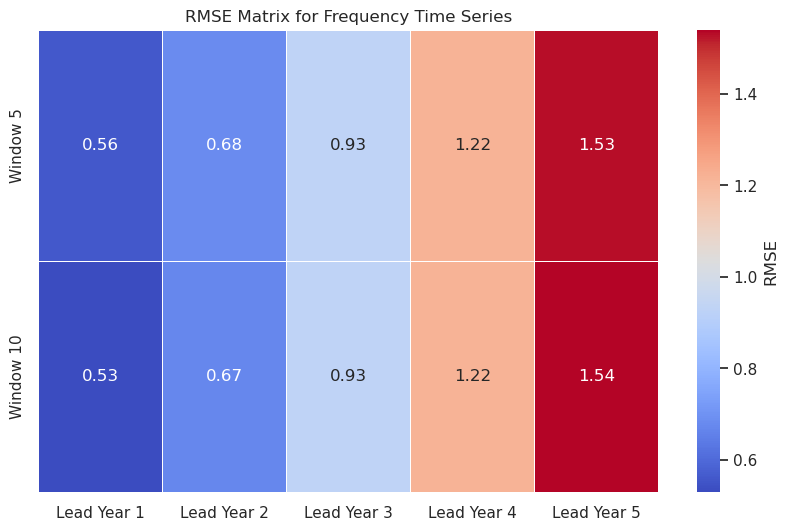

In [16]:


# RMSE values
rmse_values = [
    [0.56,0.68,0.93,1.22,1.53],
    [0.53,0.67,0.93,1.22,1.54]
]

# Lead years and window sizes
lead_years = ['Lead Year 1', 'Lead Year 2', 'Lead Year 3', 'Lead Year 4','Lead Year 5']
window_sizes = ['Window 5', 'Window 10']

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(rmse_values, columns=lead_years, index=window_sizes)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'RMSE'})
plt.title('RMSE Matrix for Frequency Time Series')
plt.show()
